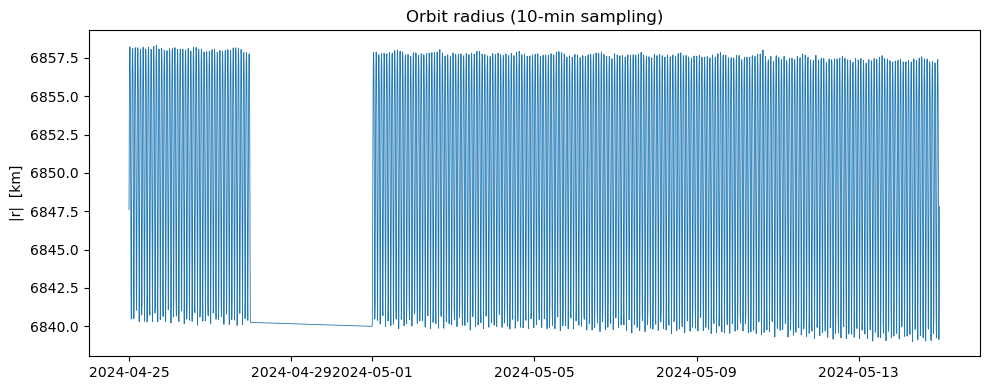

In [1]:
# 01_data_exploration.ipynb

import os, json, pathlib
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

RAW_PATH   = "GPS_measurements.parquet"

# ────────────────────────────────────────────────────────────────
# 0. LOAD  (long → wide)
# ────────────────────────────────────────────────────────────────
gps_long = pd.read_parquet(RAW_PATH).rename(columns={"datetime": "time"})

gps_wide = (
    gps_long
    .pivot_table(index="time", columns="ECEF", values=["position", "velocity"])
    .reset_index()
)
gps_wide.columns = (
    ["time"] +
    [f"{c[0]}_{c[1]}" for c in gps_wide.columns[1:]]
)
pos_cols = [c for c in gps_wide.columns if c.startswith("position_")]
vel_cols = [c for c in gps_wide.columns if c.startswith("velocity_")]

# ────────────────────────────────────────────────────────────────
# 1. UNIT CONVERSIONS
# ────────────────────────────────────────────────────────────────
df = gps_wide.copy()
df["time"] = pd.to_datetime(df["time"]).dt.floor("s")
df[pos_cols] *= 1_000      # km → m
df[vel_cols] /= 10         # dm s⁻¹ → m s⁻¹

# ────────────────────────────────────────────────────────────────
# 2. 3-σ OUTLIER FILTER on |r|
# ────────────────────────────────────────────────────────────────
r_norm_km = np.linalg.norm(df[pos_cols].values, axis=1) / 1_000
mask      = np.abs((r_norm_km - r_norm_km.mean()) / r_norm_km.std()) <= 3
df_clean  = df[mask].reset_index(drop=True)

# ────────────────────────────────────────────────────────────────
# 3. QUICK PLOT  (every 10 min)
# ────────────────────────────────────────────────────────────────
import hashlib, json
from pint import UnitRegistry; u = UnitRegistry()

# 3a) units‐safety check with pint (km → m)
df[pos_cols] = (df[pos_cols].values * u.kilometre).to(u.metre).m

# 3b) cache clean set only if changed
hash_now = hashlib.sha1(pd.util.hash_pandas_object(df_clean, index=True).values).hexdigest()[:8]
meta = {"hash": hash_now, "rows": len(df_clean)}
with open(".clean_meta.json","w") as f:
    json.dump(meta, f)

# 3c) original orbit‐radius plot
plt.figure(figsize=(10,4))
plt.plot(df_clean["time"][::600], r_norm_km[mask][::600], lw=0.6)
plt.ylabel("|r|  [km]")
plt.title("Orbit radius (10-min sampling)")
plt.tight_layout()
plt.show()
